# LENS ANTI_DISTORTION

Основано на данных работах: <br>
>[fisheyegl](https://github.com/jywarren/fisheyegl) <br>
>[iFish](https://github.com/Gil-Mor/iFish)


In [1]:
import cv2
from functions import *

<p align="center"> <img align="center" src="./images/example.png" alt="kolesnokov__dima"  /> </center>  
<p align="center"> Рисунок - Виды дисторсии (бочкообразность и подушкообразность) </center>  

Значения x_distortion, y_distortion со знаком минус говорят о том, что реализуется избавление исходного изображения от бочкообразности. Если изображение исходное подушкообразное, то необходимо ставить данные значения со знаком +

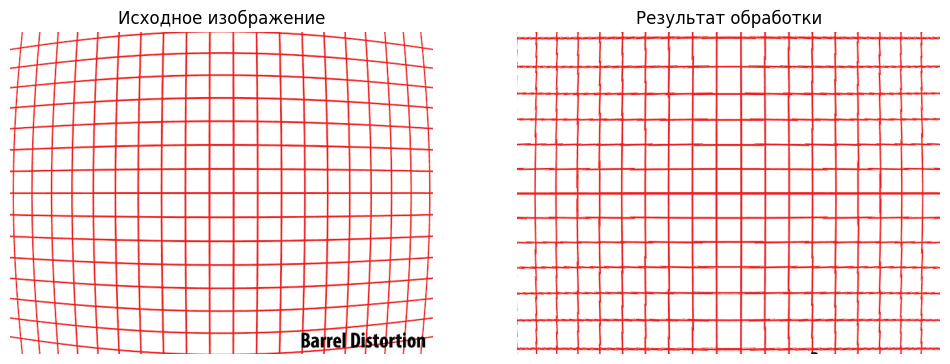

In [2]:
img_bgr = cv2.imread("images/grid.png")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Перевод и bgr в rgb
output_img = distortion(img, -0.12, -0.025)  # Идеальные параметры для данного случая
plot_result(img, output_img)

Пример с добавлением в функцию значений рескейлинга по оси x и y:

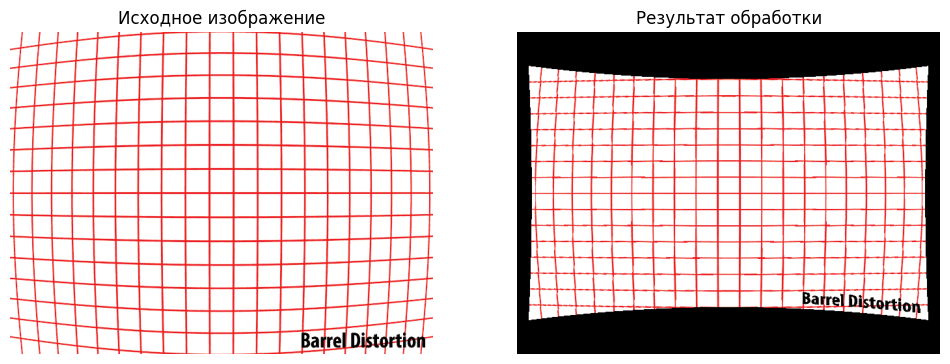

In [3]:
output_img = distortion(img, -0.12, -0.025, scale_x=1.1, scale_y=1.5)  # Идеальные параметры
plot_result(img, output_img)

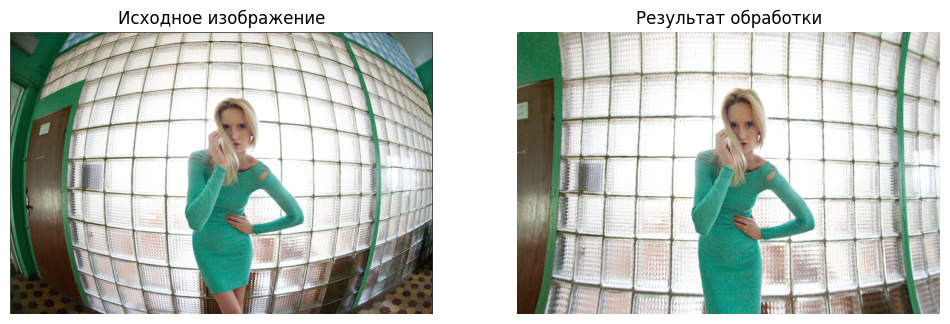

In [4]:
img_bgr = cv2.imread('images/wide_angle_camera.png')
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
output_img = distortion(img, -0.35, -0.15)
plot_result(img, output_img)

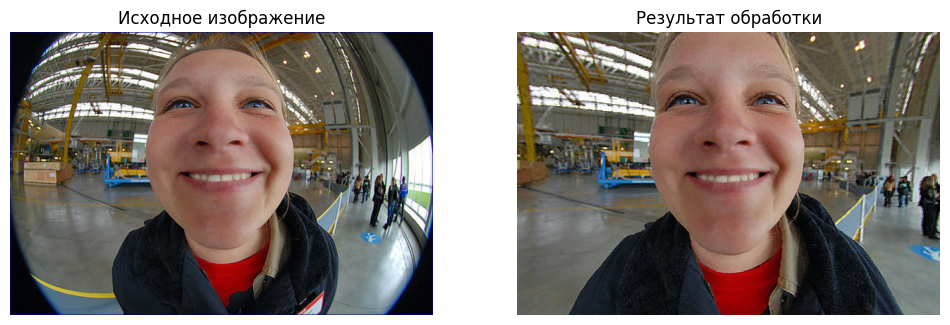

In [5]:
img_bgr = cv2.imread("images/fish_eye.jpg")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Перевод и bgr в rgb
output_img = distortion(img, -0.2, -0.3)
plot_result(img, output_img)

Пример создания бочкообразной дисторсии на обычной фотографии:
(ставим коээфициенты с x_distortion, y_distortion плюсом)

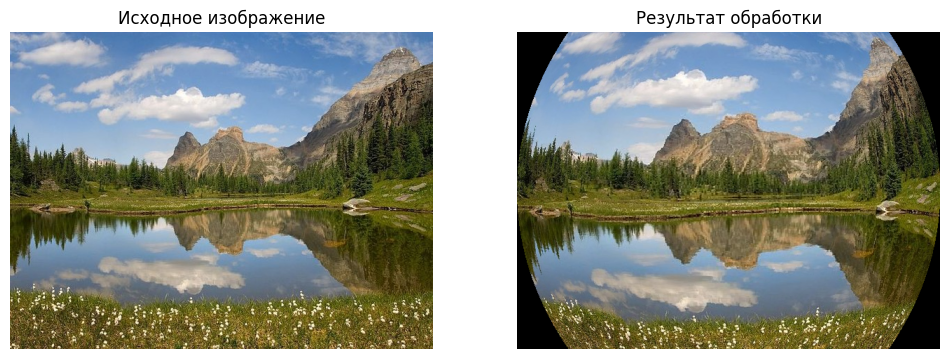

In [6]:
img_bgr = cv2.imread("images/no_distortion.jpg")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Перевод и bgr в rgb
output_img = distortion(img, 0.1, 0.3, 0.7, 0.8)
plot_result(img, output_img)

__Попытка создать интерактивное окно с возможность менять параметры y_distortion и x_distortion в реальном времени:__

Пример функций для создания интерактивного окна для выполнения процедуры антидисторсии для фотографии:

In [8]:
#interctive_window("images/wide_angle_camera.png")

Пример функций для создания интерактивного окна для выполнения процедуры добавления аберрации "дисторсия" для фотографии:

In [9]:
#interctive_window("images/no_distortion.jpg", make_distortion=True)